In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Source for this section: https://medium.com/@osanchez2323/web-scraping-nba-stats-4b4f8c525994
# This Section is uses web scraping to pull the data from Basketball Reference 

years = range(1980, 2023)
stats = []
for year in years:
    url = "https://www.basketball-reference.com/leagues/NBA_" + str(year) + "_per_game.html"
    html = urlopen(url)
    soup = BeautifulSoup(html)
    features = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
    features = features[1:]
    data = soup.findAll('tr')[:]
    season_stats = [[td.getText() for td in data[i].findAll('td')]
            for i in range(len(data))]
    temp = pd.DataFrame(season_stats, columns = features)
    temp['Season'] = year
    stats.append(temp[1:])
    
    

In [3]:
# Make sure that all of the numerical data is the correct data type
i = 0
print(stats[0].columns)
for year in stats:
    columns = year.columns
    columns = columns[columns != 'Player']
    columns = columns[columns != 'Tm']
    columns = columns[columns != 'Pos']
    for column in columns:
        stats[i][column] = pd.to_numeric(stats[i][column])
    i = i+1

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Season'],
      dtype='object')


/home/levikaster/miniconda3/envs/cse217a/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [4]:
# Removes all Data Points where the athlete played less than half of the season
i=0
for year in stats:
    stats[i] = year[year['G'] > 40]
    i = i + 1

In [5]:
# Creates a Second Dataset containing just the player name, points, rebounds, and assists. 

join = stats[1:]
i = 0
for season in join:
    narrowed = season[['Player','PTS', 'TRB', 'AST']]
    join[i] = narrowed.rename(columns={'PTS': 'Target_PTS', 'TRB': 'Target_TRB', 'AST': 'Target_AST'})
    i = i + 1

In [6]:
# Merges the inital dataset with the next season of the newly created one. This adds the target features to the dataset
# Now our Dataset has the next

stats_updated = stats[0:len(stats) - 1]
joined = []
i = 0
for season in stats_updated:
    joined.append(season.merge(join[i]))
    i = i + 1
joined[0].shape

(206, 33)

In [7]:
# Remove all datapoints where a player's statistics come from multiple teams in a given year
i = 0
for season in joined:
    joined[i] = season[season['Tm'] != 'TOT']
    i = i + 1

In [8]:
final = joined[0]
i = 0
for season in joined:
    if i != 0:
        final = final.append(season)
    i = i + 1

In [9]:
# Remove the 'Games Started' column because it shouldn't contain important information and has many unfilled data points
final = final.drop('GS', axis=1)

In [10]:
# Remove all unfilled Data Points with 0 since a NaN means that the athlete did not take that kind of shot
for column in final.columns:
    final[column] = final[column].fillna(0)
        

[186, 208, 210, 199, 207, 199, 191, 214, 212, 228, 232, 225, 237, 228, 227, 260, 257, 255, 179, 179, 260, 244, 248, 268, 266, 253, 256, 270, 256, 257, 289, 224, 245, 274, 286, 269, 278, 272, 280, 244, 230, 239]


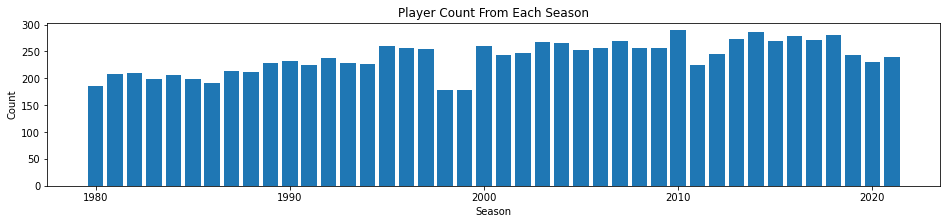

In [11]:
# Create A Graph Showing the amount of Data Points from each season over time
counts = []
for year in np.unique(final['Season']):
    counts.append(len(final['Season'][final['Season'] == year]))
print(counts)

plt.figure(figsize=(16, 3))
plt.bar(np.unique(final['Season']), counts)
plt.title('Player Count From Each Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()


In [12]:
final.shape

(10041, 32)

In [13]:
# Save the csv
final.to_csv('NBA_Player_StatsV2.csv')

In [34]:
# Creates a dataset representing all of the data from the most recent nba season, as such there are no target features
# This is not used in our paper
current = stats[42]
current = current.drop('GS', axis=1)
for column in current.columns:
    current[column] = current[column].fillna(0)

In [38]:
current.to_csv('Current_Stats.csv')